# EECS 598 Variational Autoencoders tutorial
(This tutorial is based on this repository: https://github.com/jojonki/AutoEncoders/blob/master/vae.ipynb)

<img src="vae.png"/>

The variational autoencoder (VAE) is a directed graphical model defined by a generative model $p_\theta(\mathbf{x}|\mathbf{z})p_\theta(\mathbf{z})$ (solid lines), and an approximate posterior distribution $q_\theta(\mathbf{z}|\mathbf{x})$(dotted lines) that approximates the true posterior $p_\theta(\mathbf{z}|\mathbf{x})$. $q_\theta(\mathbf{z}|\mathbf{x})$ is typically referred to as recognition model.
The VAEs are trained by maximimizing the variational lower bound denoted as $\mathcal{L}\left(\theta,\phi;\mathbf{x}^{\left(i\right)}\right)$:

$$
\begin{align} 
\log p_{\theta}\left(\mathbf{x}^{\left(i\right)}\right) &\geq \mathcal{L}\left(\theta,\phi;\mathbf{x}^{\left(i\right)}\right) \nonumber \\
&= \mathbb{E}_{q_{\phi}\left(\mathbf{z}|\mathbf{x}^{\left(i\right)}\right)}\left[\log p_{\theta}\left(\mathbf{x}^{\left(i\right)}|\mathbf{z}\right)\right] -D_{KL}\left(q_{\phi}\left(\mathbf{z}|\mathbf{x}^{\left(i\right)}\right)\|p_{\theta}\left(\mathbf{z}\right)\right), \nonumber
\end{align}
$$

where $\mathbb{E}_{q_{\phi}\left(\mathbf{z}|\mathbf{x}^{\left(i\right)}\right)}\left[\log p_{\theta}\left(\mathbf{x}^{\left(i\right)}|\mathbf{z}\right)\right]$ measures the expected log-likelihood of the data point $\mathbf{x}^{\left(i\right)}$ given the latent variable $\mathbf{z}$ under the distribution $q_{\phi}\left(\mathbf{z}|\mathbf{x}^{\left(i\right)}\right)$ defined by the recognition model. The second term,  $D_{KL}\left(q_{\phi}\left(\mathbf{z}|\mathbf{x}^{\left(i\right)}\right)\|p_{\theta}\left(\mathbf{z}\right)\right)$, measures how close the $q_{\phi}\left(\mathbf{z}|\mathbf{x}^{\left(i\right)}\right)$ is to the prior distribution $p_{\theta}\left(\mathbf{z}\right)$.


Given the previous definitions, let us build a VAE where the assumed distribution is Gaussian. Let us start by building the recognition model as a two-layer neural network that outputs the Gaussian parameters $\mathbf{\mu}$ and $\mathbf{\sigma}$. Note: To make things easier have the recognition network, output $\text{log}\ \mathbf{\sigma}^2$ (i.e., a simple linear output):

In [21]:
# https://qiita.com/kenmatsu4/items/b029d697e9995d93aa24
from __future__ import print_function
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
%matplotlib inline 

In [22]:
# Load MNIST dataset
use_cuda = False
input_size = 28 * 28
units = 400
batch_size = 32
latent_size = 20 # z dim
dummy_data = torch.from_numpy(1 / (1 + np.exp(-np.random.normal(size=(1, input_size))))).float()

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.ToTensor()),
        batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False,
                       transform=transforms.ToTensor()),
        batch_size=batch_size, shuffle=True, **kwargs)

In [23]:
# Helper function to put variables in GPU or not
# In our case we run this in CPU
def to_var(x):
    x = Variable(x)
    if use_cuda:
        x = x.cuda()
    return x

In [24]:
class VAE(nn.Module): # 10 min
    def __init__(self, input_size, latent_size, units):
        super(VAE, self).__init__()
        
        self.input_size = input_size
        self.units = units
        self.relu = nn.ReLU()

        # recognition model
        self.fc1 = nn.Linear(input_size, self.units)
        self.fc2 = nn.Linear(self.units, self.units)
        self.layer_mu = nn.Linear(self.units, latent_size)
        self.layer_logvar = nn.Linear(self.units, latent_size)

    def recognition_model(self, x):
        h1 = self.relu(self.fc1(x))
        h2 = self.relu(self.fc2(h1))
        z_mu = self.layer_mu(h2)
        z_logvar = self.layer_logvar(h2)
        return z_mu, z_logvar

In [25]:
## CHECK THAT MU AND LOGVAR OUTPUT SHAPES MAKE SENSE
model = VAE(input_size, latent_size, units)
dummy_data = to_var(dummy_data)
test_mu, test_logvar = model.recognition_model(dummy_data)
assert list(test_mu.shape) == [1, latent_size] and list(test_logvar.shape) == [1, latent_size]
print('Recognition model outputs shape passed successufully!')

Recognition model outputs shape passed successufully!


Now, let us implement a function that, given the $\mathbf{\mu}$ and $\mathbf{\sigma}$ from the recognition model, we can use to sample a latent variable $\mathbf{z}$. In VAEs, this sampling procedure is done by applying the Gaussian $\textit{reparametrization}$ trick:
$$
\begin{equation} 
\mathbf{z} = \mathbf{\mu} + \mathbf{\sigma} \odot \epsilon, \nonumber
\end{equation}
$$
where $\epsilon\sim\mathcal{N}(\mathbf{0},\mathbf{I})$ and $\odot$ means elementwise multiplication. Note: The sample function takes in logvar so make sure you compute sigma when applying the reparametrization trick.


In [26]:
class VAE(nn.Module): # 10 min
    def __init__(self, input_size, latent_size, units):
        super(VAE, self).__init__()
        
        self.input_size = input_size
        self.units = units
        self.relu = nn.ReLU()

        # recognition model
        self.fc1 = nn.Linear(input_size, self.units)
        self.fc2 = nn.Linear(self.units, self.units)
        self.layer_mu = nn.Linear(self.units, latent_size)
        self.layer_logvar = nn.Linear(self.units, latent_size)

    def recognition_model(self, x):
        h1 = self.relu(self.fc1(x))
        h2 = self.relu(self.fc2(h1))
        z_mu = self.layer_mu(h2)
        z_logvar = self.layer_logvar(h2)
        return z_mu, z_logvar

    def reparametrize(self, mu, logvar):
        epsilon = Variable(mu.data.new(mu.size()).normal_())
        sigma = torch.exp(0.5 * logvar)
        z = mu + sigma * epsilon
        return z

In [27]:
## CHECK THAT Z OUTPUT SHAPE MAKES SENSE
model = VAE(input_size, latent_size, units)
test_z = model.reparametrize(test_mu, test_logvar)
assert list(test_z.shape) == [1, latent_size]
print('Sampled z shape passed successufully!')

Sampled z shape passed successufully!


Now, let us implement a two-layer generative model $p_{\theta}\left(\mathbf{x}^{\left(i\right)}|\mathbf{z}\right)$. For this exercise, we are assuming a bernoulli distribution in the output. Therefore, make sure your output is binary.

In [28]:
class VAE(nn.Module): # 10 min
    def __init__(self, input_size, latent_size, units):
        super(VAE, self).__init__()
        
        self.input_size = input_size
        self.units = units
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        # recognition model
        self.fc1 = nn.Linear(input_size, self.units)
        self.fc2 = nn.Linear(self.units, self.units)
        self.layer_mu = nn.Linear(self.units, latent_size)
        self.layer_logvar = nn.Linear(self.units, latent_size)

        # generation model
        self.fc3 = nn.Linear(latent_size, self.units)
        self.fc4 = nn.Linear(self.units, self.units)
        self.layer_output = nn.Linear(self.units, input_size)
          
    def recognition_model(self, x):
        h1 = self.relu(self.fc1(x))
        h2 = self.relu(self.fc2(h1))
        z_mu = self.layer_mu(h2)
        z_logvar = self.layer_logvar(h2)
        return z_mu, z_logvar

    def reparametrize(self, mu, logvar):
        epsilon = Variable(mu.data.new(mu.size()).normal_())
        sigma = torch.exp(0.5 * logvar)
        z = mu + sigma * epsilon
        return z

    def generation_model(self, z):
        h3 = self.relu(self.fc3(z))
        h4 = self.relu(self.fc4(h3))
        x_hat = self.sigmoid(self.layer_output(h4))
        return x_hat

In [29]:
## CHECK THAT GENERATION MODEL OUTPUT SHAPES MAKE SENSE
model = VAE(input_size, latent_size, units)
test_output = model.generation_model(test_z)
assert list(test_output.shape) == [1, input_size]
print('Generation model outputs shape passed successufully!')

Generation model outputs shape passed successufully!


Now, let us put everything together as a feedforward neural network. Specifically, first infer the latent variable z using the recognition_model function, and then follow by generating $\mathbf{x}^{(i)}$ using the generation_model.

In [30]:
class VAE(nn.Module):
    def __init__(self, input_size, latent_size, units):
        super(VAE, self).__init__()
        
        self.input_size = input_size
        self.units = units
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        # recognition model
        self.fc1 = nn.Linear(input_size, self.units)
        self.fc2 = nn.Linear(self.units, self.units)
        self.layer_mu = nn.Linear(self.units, latent_size)
        self.layer_logvar = nn.Linear(self.units, latent_size)

        # generation model
        self.fc3 = nn.Linear(latent_size, self.units)
        self.fc4 = nn.Linear(self.units, self.units)
        self.layer_output = nn.Linear(self.units, input_size)
            
    def recognition_model(self, x):
        h1 = self.relu(self.fc1(x))
        h2 = self.relu(self.fc2(h1))
        z_mu = self.layer_mu(h2)
        z_logvar = self.layer_logvar(h2)
        return z_mu, z_logvar

    def reparametrize(self, mu, logvar):
        epsilon = Variable(mu.data.new(mu.size()).normal_())
        sigma = logvar.mul(0.5).exp_()
        z = mu + sigma * epsilon
        return z

    def generation_model(self, z):
        h3 = self.relu(self.fc3(z))
        h4 = self.relu(self.fc4(h3))
        x_hat = self.sigmoid(self.layer_output(h4))
        return x_hat
    
    def forward(self, x):
        mu, logvar = self.recognition_model(x.view(-1, input_size))
        z = self.reparametrize(mu, logvar)
        x_hat = self.generation_model(z)
        return x_hat, mu, logvar

In [31]:
## CHECK THAT VAE MODEL OUTPUT SHAPES MAKE SENSE
model = VAE(input_size, latent_size, units)
test_output, test_mu, test_logvar = model.forward(dummy_data)
assert list(test_output.shape) == [1, input_size] and list(test_mu.shape) == [1, latent_size] and list(test_logvar.shape) == [1, latent_size]
print('Full VAE model outputs shape passed successufully!')

Full VAE model outputs shape passed successufully!


Finally, we need to implement the objective function. Specifically, we want to maximize $\mathcal{L}\left(\theta,\phi;\mathbf{x}^{\left(i\right)}\right)$. To implement it as a minimization problem we want to minimize $-\mathcal{L}\left(\theta,\phi;\mathbf{x}^{\left(i\right)}\right)$. Therefore, we want to implement $-\mathbb{E}_{q_{\phi}\left(\mathbf{z}|\mathbf{x}^{\left(i\right)}\right)}\left[\log p_{\theta}\left(\mathbf{x}^{\left(i\right)}|\mathbf{z}\right)\right]$ which, $\textbf{in this tutorial}$, turns out to be the binary cross-entropy between a target output and the output generated (Note: when we work with real values we use a Gaussian distribution which turns out to be MSE):
$$
\begin{equation}
\mathbb{E}_{q_{\phi}\left(\mathbf{z}|\mathbf{x}^{\left(i\right)}\right)}\left[\log p_{\theta}\left(\mathbf{x}^{\left(i\right)}|\mathbf{z}\right)\right] = BCE(\mathbf{x}^{(i)}, \hat{\mathbf{x}}^{(i)}) \nonumber
\end{equation}
$$
Now, as defined before, the second term in the variational lower bound is $D_{KL}\left(q_{\phi}\left(\mathbf{z}|\mathbf{x}^{\left(i\right)}\right)\|p_{\theta}\left(\mathbf{z}\right)\right)$. In traditional VAE, $p_{\theta}\left(\mathbf{z}\right)$ is assumed to be a standard gaussian distribution $\mathcal{N}(\mathbf{0}, \mathbf{I})$. Therefore, the objective turns out to be:
$$
\begin{equation}
D_{KL}\left(q_{\phi}\left(\mathbf{z}|\mathbf{x}^{\left(i\right)}\right)\|p_{\theta}\left(\mathbf{z}\right)\right) = -\frac{1}{2}\sum_{j=1}^{J}\left(1+\log\left(\sigma_{j}^{2}\right)-\mu_{j}^{2}-\sigma_{j}^{2}\right) \nonumber
\end{equation}
$$
where $\mu_j$ and $\sigma_j$ are the $j$-th element in the recognition network outputs. Given this, let us implement the objective function (None: remember the output of the recognition network is $\text{log} \sigma^2$ so you need to convert it to $\sigma$:

In [12]:
def loss_function(x_hat, x, mu, logvar):
    BCE = F.binary_cross_entropy(x_hat, x.view(-1, input_size), size_average=False)
    DKL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return (BCE + DKL) / x.shape[0]

In [13]:
## CHECK THAT LOSS OUTPUT SHAPE IS OF A SINGLE VALUE
test_loss = loss_function(test_output, dummy_data, test_mu, test_logvar)
assert len(test_loss.shape) == 0
print('Loss output shape passed!')

Loss output shape passed!


/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [14]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = to_var(data)
        recon_batch, mu, logvar = model(data)
        optimizer.zero_grad()
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.data.numpy()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.data.numpy() / len(data)))

def test(epoch):
    model.eval()
    test_loss = 0
    for i, (data, labels) in enumerate(test_loader):
        data = to_var(data)
        recon_batch, mu, logvar = model(data)
        test_loss += loss_function(recon_batch, data, mu, logvar).data[0]
        if i == 0:
            n = min(data.size(0), 8)
            comparison = torch.cat([data[:n],
                                  recon_batch.view(batch_size, 1, 28, 28)[:n]])
            save_image(comparison.data.cpu(),
                     'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [15]:
# Create full VAE model
model = VAE(input_size, latent_size, units)

In [16]:
if use_cuda:
    model.cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [17]:
for epoch in range(1, 10):
    train(epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 17.046820
Train Epoch: 1 [16000/60000 (27%)]	Loss: 4.886394
Train Epoch: 1 [32000/60000 (53%)]	Loss: 3.742534
Train Epoch: 1 [48000/60000 (80%)]	Loss: 4.282438
Train Epoch: 2 [0/60000 (0%)]	Loss: 3.621556
Train Epoch: 2 [16000/60000 (27%)]	Loss: 3.419511
Train Epoch: 2 [32000/60000 (53%)]	Loss: 3.384707
Train Epoch: 2 [48000/60000 (80%)]	Loss: 3.540358
Train Epoch: 3 [0/60000 (0%)]	Loss: 3.609036
Train Epoch: 3 [16000/60000 (27%)]	Loss: 3.747828
Train Epoch: 3 [32000/60000 (53%)]	Loss: 3.457808
Train Epoch: 3 [48000/60000 (80%)]	Loss: 3.684580
Train Epoch: 4 [0/60000 (0%)]	Loss: 3.253793
Train Epoch: 4 [16000/60000 (27%)]	Loss: 3.365650
Train Epoch: 4 [32000/60000 (53%)]	Loss: 3.512387
Train Epoch: 4 [48000/60000 (80%)]	Loss: 3.313873
Train Epoch: 5 [0/60000 (0%)]	Loss: 3.075836
Train Epoch: 5 [16000/60000 (27%)]	Loss: 3.381061
Train Epoch: 5 [32000/60000 (53%)]	Loss: 3.462044
Train Epoch: 5 [48000/60000 (80%)]	Loss: 3.198418
Train Epoch: 6 [0/60000 

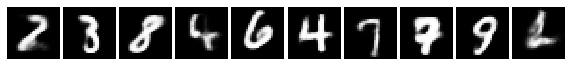

In [18]:
# Let's sample some data
model.eval()

z_random = torch.from_numpy(np.random.normal(size=(10, latent_size))).float()
samples = model.generation_model(z_random).data.cpu().numpy()

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(10, 10)
gs.update(wspace=0.05, hspace=0.05)
for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

Transition labels: tensor(8) --> tensor(2)


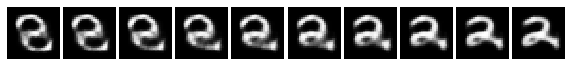

In [19]:
# Let's see a transition from labels[0] to labels[1]
model.eval()
for i, (data, labels) in enumerate(test_loader):
    data = to_var(data)
    mu, logvar = model.recognition_model(data.view(-1, input_size))
    z = model.reparametrize(mu, logvar)
    print('Transition labels:', labels[0], '-->', labels[1])
    z_cont = to_var(torch.zeros(10, latent_size))
    for i in range(10):
        t = 1.0 - i/9
        z_cont[i] = t * z[0] + (1-t) * z[1]
    samples = model.generation_model(z_cont).data.cpu().numpy()

    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(10, 10)
    gs.update(wspace=0.05, hspace=0.05)
    for i, sample in enumerate(samples):
            ax = plt.subplot(gs[i])
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            plt.imshow(sample.reshape(28, 28), cmap='Greys_r')
    break

(1000, 2)


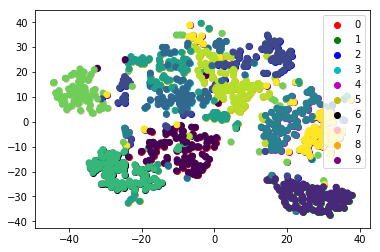

In [20]:
from sklearn.manifold import TSNE

model.eval()
z_list = None
l_list = []
for i, (data, labels) in enumerate(test_loader):
    data = to_var(data)
    mu, logvar = model.recognition_model(data.view(-1, 28*28))
    z = mu
    if i == 0:
        z_list = z
        l_list = labels
    else:
        z_list = torch.cat((z_list, z), 0)
        l_list = torch.cat((l_list, labels), 0)

z_list = z_list.data.cpu().numpy()[:1000]
l_list = l_list.cpu().numpy()[:1000] # labels are not Variable

# Visualization using TSNE
X_reduced = TSNE(n_components=2, random_state=0).fit_transform(z_list)

print (X_reduced.shape)
# (N, 2)
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'pink', 'orange', 'purple'
for i, c in enumerate(colors):
    plt.scatter(X_reduced[l_list == i, 0], X_reduced[l_list == i, 1], c=c, label=str(i))

plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=l_list)
plt.legend()